## VGG16神经网络

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

### 定义超参数

In [ ]:
TRAIN_BATCH_SIZE = 500
TEST_BATCH_SIZE = 100
EPOCH = 150

# 定义训练的设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### torchvision模块载入CIFAR10数据集，并且通过transform归一化到[0,1]

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data',train = True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size = TRAIN_BATCH_SIZE, shuffle = True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',train = False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size = TEST_BATCH_SIZE, shuffle = False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

Files already downloaded and verified


### 定义VGG16神经网络模型

In [ ]:
class Vgg16_Net(nn.Module):
  def __init__(self):
    super(Vgg16_Net, self).__init__()
    #2个卷积层和1个最大池化层
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 3, stride=1, padding=1), # (32-3+2)/1+1 = 32  32*32*64
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(64,64, kernel_size = 3, stride=1, padding=1), # (32-3+2)/1+1 = 32  32*32*64
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        
        nn.MaxPool2d(2, 2) # (32-2)/2+1 = 16    16*16*64
        
        )
    #2个卷积层和1个最大池化层
    self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size = 3, stride=1, padding=1), # (16-3+2)/1+1 = 16  16*16*128
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),

        nn.Conv2d(128, 128, kernel_size = 3, stride=1, padding=1), # (16-3+2)/1+1 = 16  16*16*128
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        
        nn.MaxPool2d(2, 2) # (16-2)/2+1 = 8    8*8*128
        )
    #3个卷积层和1个最大池化层
    self.layer3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size = 3, stride=1, padding=1), # (8-3+2)/1+1 = 8  8*8*256
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),

        nn.Conv2d(256, 256, kernel_size = 3, stride=1, padding=1), # (8-3+2)/1+1 = 8  8*8*256
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),

        nn.Conv2d(256, 256, kernel_size = 3, stride=1, padding=1), # (8-3+2)/1+1 = 8  8*8*256
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        
        nn.MaxPool2d(2, 2), # (8-2)/2+1 = 4    4*4*256
        )
    #3个卷积层和1个最大池化层
    self.layer4 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size = 3, stride=1, padding=1), # (4-3+2)/1+1 = 4  4*4*512
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),

        nn.Conv2d(512, 512, kernel_size = 3, stride=1, padding=1), # (4-3+2)/1+1 = 4  4*4*512
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),

        nn.Conv2d(512, 512, kernel_size = 3, stride=1, padding=1), # (4-3+2)/1+1 = 4  4*4*512
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        
        nn.MaxPool2d(2, 2) # (4-2)/2+1 = 2    2*2*512
        )
    #3个卷积层和1个最大池化层
    self.layer5 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size = 3, stride=1, padding=1), # (2-3+2)/1+1 = 2  2*2*512
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),

        nn.Conv2d(512, 512, kernel_size = 3, stride=1, padding=1), # (2-3+2)/1+1 = 2  2*2*512
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),

        nn.Conv2d(512, 512, kernel_size = 3, stride=1, padding=1), # (2-3+2)/1+1 = 2  2*2*512
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        
        nn.MaxPool2d(2, 2) # (2-2)/2+1 = 1    1*1*512
        )
    self.conv = nn.Sequential(
        self.layer1,
        self.layer2,
        self.layer3,
        self.layer4,
        self.layer5
        )
    self.fc = nn.Sequential(    
        nn.Linear(512, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),

        nn.Linear(256, 10)
        )

  def forward(self, x):
    x = self.conv(x)
    x = x.view(-1, 512)
    x = self.fc(x)
    return x

net = Vgg16_Net()
net = net.to(device) # 在 GPU 上进行训练

### 损失函数和优化器

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
loss_func =torch.nn.CrossEntropyLoss() # 预测值和真实值的误差计算公式 (交叉熵)
loss_func = loss_func.to(device) # 在 GPU 上进行训练

### VGG16训练

In [ ]:
start_time = time.time() # 开始训练的时间
accuracy_list = []
for epoch in range(EPOCH):
  for step, (b_x,b_y)in enumerate(trainloader):
    b_x = b_x.to(device)
    b_y = b_y.to(device)
    outputs = net(b_x) # 喂给 net 训练数据 x, 输出预测值
    loss = loss_func(outputs, b_y) # 计算两者的误差
    optimizer.zero_grad() # 清空上一步的残余更新参数值
    loss.backward() # 误差反向传播, 计算参数更新值
    optimizer.step() # 将参数更新值施加到 net 的 parameters 上
    step += 1
    # 打印状态信息
    if step % 100 == 0:    # 每100批次打印一次
      end_time = time.time()  # 训练结束时间
      print("训练时间: {}".format(end_time - start_time))
      print("Loss: {}".format(loss))

  total_test_loss = 0
  total_accuracy = 0
  test_data_size = 0
  with torch.no_grad():
    #不计算梯度，节省时间
    for (images,labels) in testloader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = net(images)
      loss = loss_func(outputs, labels)
      total_test_loss += loss
      test_data_size += labels.size(0)
      numbers,predicted = torch.max(outputs.data,1)
      total_accuracy+=(predicted==labels).sum().item()   # 相加

  print("整体测试集上的loss: {}".format(total_test_loss))
  print("整体测试集上的正确率: {}".format(total_accuracy / test_data_size))
  accuracy_list.append(total_accuracy / test_data_size)
  total_test_loss += 1   

print('Finished Training')
print("训练{}次后的正确率为{}".format(EPOCH, accuracy_list[-1]))

训练时间: 21.249516248703003
Loss: 1.9514856338500977
整体测试集上的loss: 194.77757263183594
整体测试集上的正确率: 0.2633
训练时间: 45.21202540397644
Loss: 1.6621763706207275
整体测试集上的loss: 161.27288818359375
整体测试集上的正确率: 0.3796
训练时间: 69.90561866760254
Loss: 1.335180640220642
整体测试集上的loss: 141.8339385986328
整体测试集上的正确率: 0.4756
训练时间: 94.23009991645813
Loss: 1.1611220836639404
整体测试集上的loss: 123.86328125
整体测试集上的正确率: 0.5542
训练时间: 118.35185050964355
Loss: 1.0253715515136719
整体测试集上的loss: 113.38715362548828
整体测试集上的正确率: 0.6041
训练时间: 142.61417365074158
Loss: 0.9190225601196289
整体测试集上的loss: 106.93866729736328
整体测试集上的正确率: 0.6322
训练时间: 167.0156228542328
Loss: 0.7748535871505737
整体测试集上的loss: 104.0252456665039
整体测试集上的正确率: 0.6471
训练时间: 191.2439901828766
Loss: 0.6840376853942871
整体测试集上的loss: 104.65533447265625
整体测试集上的正确率: 0.6626
训练时间: 215.43973660469055
Loss: 0.48057469725608826
整体测试集上的loss: 110.68110656738281
整体测试集上的正确率: 0.6658
训练时间: 239.73190331459045
Loss: 0.41966351866722107
整体测试集上的loss: 113.31746673583984
整体测试集上的正确率: 0.6709
训练

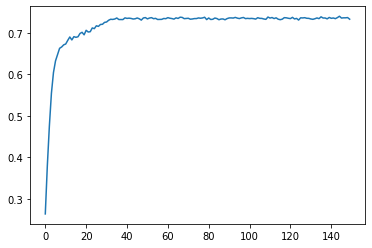

In [ ]:
plt.figure()
plt.plot(accuracy_list)
plt.show()